Import packages needed

In [59]:
#%%
#* Import the code needed
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

Set directory path

In [60]:
#%%
#* Define paths
directory_path = Path('../../')

Import datasets

In [61]:
pop = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Population' / 'regression_Population.xlsx',
    index_col=0)

PpD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'PpD' / 'regression_PpD.xlsx',
    index_col=0)

UFApD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'UFApD' / 'regression_UFApD.xlsx',
    index_col=0)

energy_intensity = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Energy_Intensity' / 'Energy_intensity_constants.xlsx',
    index_col=[0,1,2])

TS_cj = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Type_Split' / 'Type_Split_ratios.xlsx',
    index_col=0)

lifetime = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

lifetime_standard_deviation = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

Seperate out the lifetime and standard deviation datasets

In [62]:
lifetime = lifetime.drop('std_dev', axis=1)
lifetime_standard_deviation = lifetime_standard_deviation.drop('lifetime', axis=1)

lifetime = lifetime.loc[:, 'lifetime'].to_numpy()
lifetime

lifetime_standard_deviation = lifetime_standard_deviation.loc[:, 'std_dev'].to_numpy()

Import DSM module

In [63]:
# getting the name of the directory where the this file is present.
current = os.path.dirname(os.path.realpath('this'))
 
# Getting the parent directory name where the current directory is present.
parent = os.path.dirname(current)
#make the UA path
module_path = parent + '/modules'
#append path to options to import from
sys.path.append(module_path)

from dynamic_stock_model import DynamicStockModel

Calculate stock from pop/PpD

split up stock by type split ratios

In [64]:
stock_t = np.divide(pop,PpD)

stock_t_SFH = np.multiply(stock_t,TS_cj['SFH_ratio'])
stock_t_TH = np.multiply(stock_t,TS_cj['TH_ratio'])
stock_t_AB = np.multiply(stock_t,TS_cj['AB_ratio'])

Define a function that does all the stock modeling steps for us

In [65]:
def stock_model(stock):
    dwellings_stock_driven = DynamicStockModel(t=np.arange(1600, 2051),
                         s=stock_t_SFH['Population'].to_numpy(),
                         lt={'Type': 'Normal', 
                             'Mean': lifetime,
                             'StdDev': lifetime_standard_deviation 
                             }
                        )
    
    dwellings_stock_driven.compute_stock_driven_model(
        NegativeInflowCorrect = True)
    
    inflow_t = dwellings_stock_driven.i

    dwellings_inflow_driven = DynamicStockModel(t=np.arange(1600, 2051),
                    i=inflow_t,
                    lt={'Type': 'Normal', 
                        'Mean': lifetime,
                        'StdDev': lifetime_standard_deviation 
                        }
                    )
    dwellings_inflow_driven.compute_s_c_inflow_driven()

    dwellings_inflow_driven.compute_stock_total()

    dwellings_inflow_driven.compute_o_c_from_s_c()


    return dwellings_inflow_driven.s_c, dwellings_inflow_driven.s, dwellings_stock_driven.i, dwellings_stock_driven.o_c


Run the stock model function on each type, spit out:

s_c (stock by cohort)
s (total stock)
i (total)
o (outflow by cohort)


In [66]:
s_c_SFH, s_SFH, i_SFH, o_SFH = stock_model(stock_t_SFH)
s_c_TH, s_TH, i_TH, o_TH = stock_model(stock_t_TH)
s_c_AB, s_AB, i_AB, o_AB = stock_model(stock_t_AB)

Plot all types for stock

Text(0, 0.5, 'Dwellings')

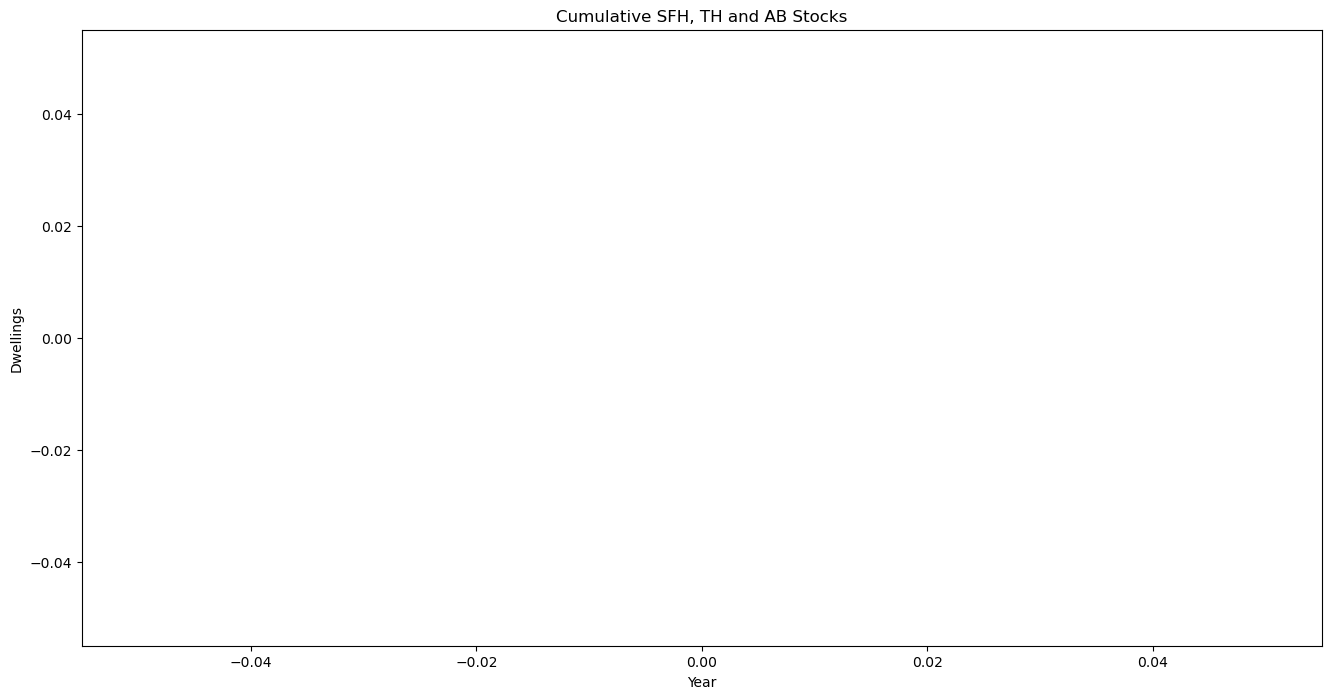

In [67]:
# Plot SFH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_SFH, s_TH, s_AB)
plt.title('Cumulative SFH, TH and AB Stocks')
plt.xlabel('Year')
plt.ylabel('Dwellings')

Plot total TH stock

Text(0, 0.5, 'dwellings')

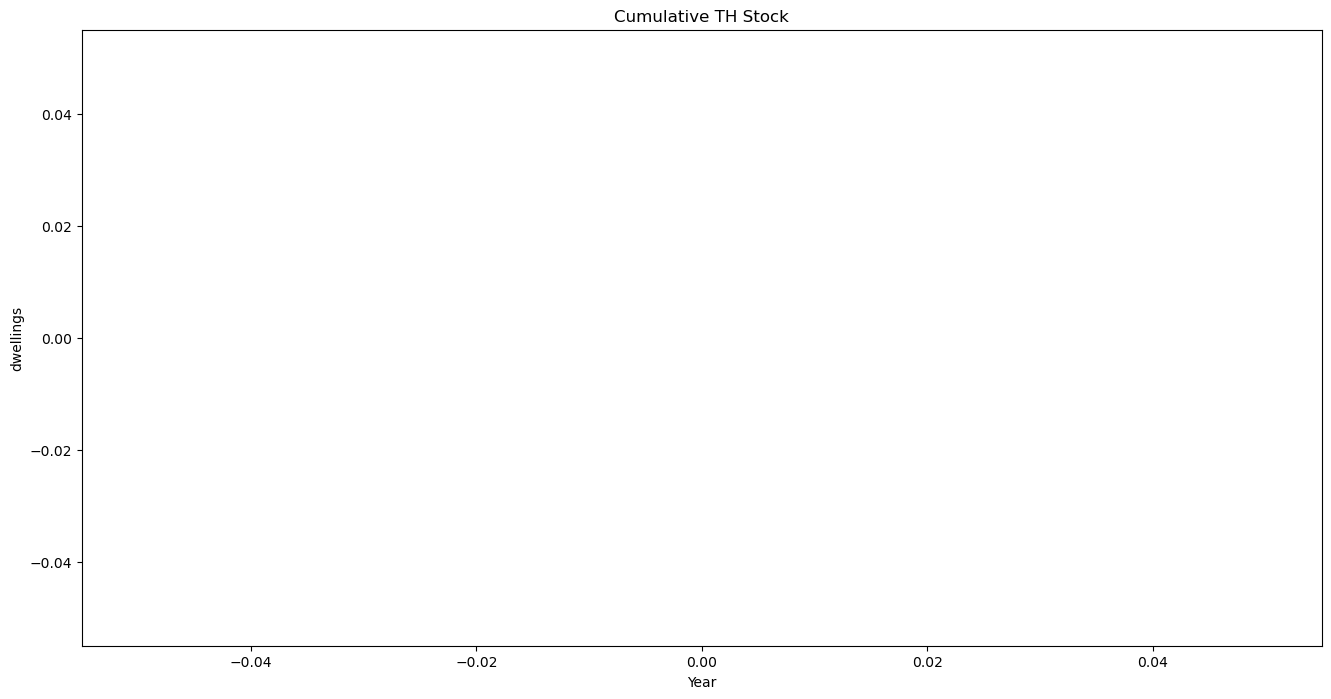

In [14]:
# Plot TH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_TH)
plt.title('Cumulative TH Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Plot total AB stock

Text(0, 0.5, 'dwellings')

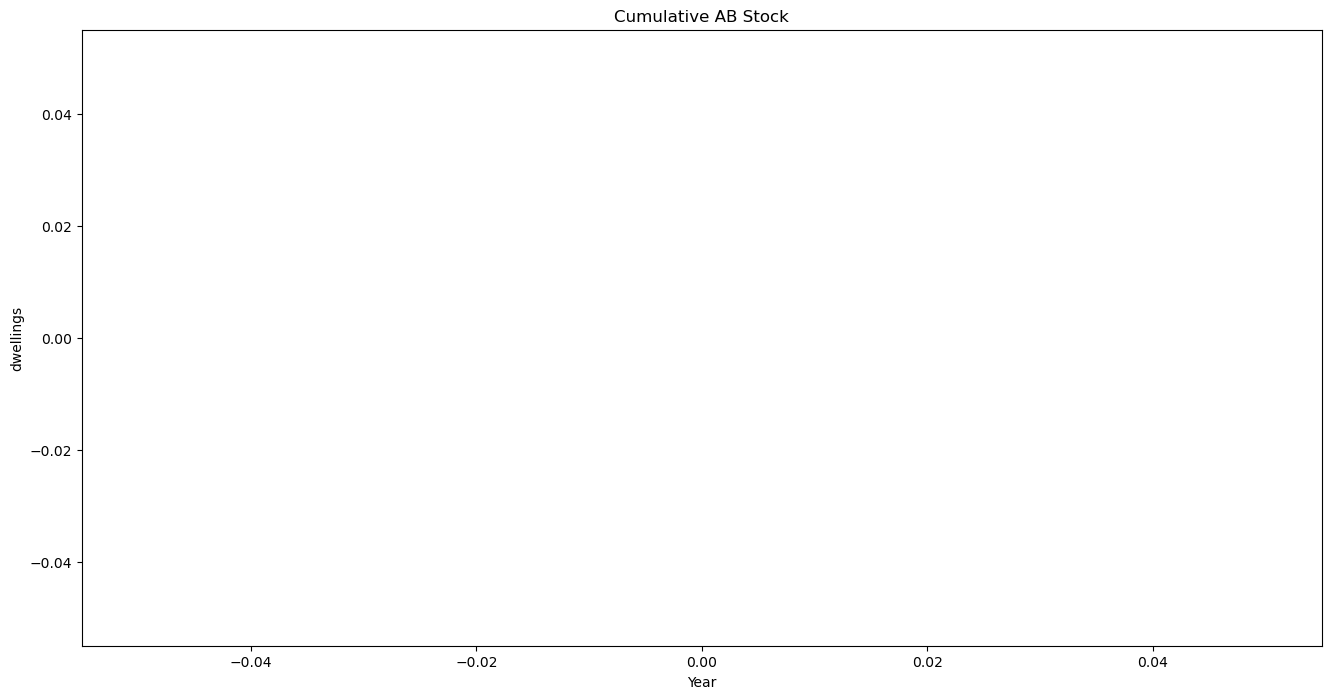

In [15]:
# Plot AB total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_AB)
plt.title('Cumulative AB Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')

Make s_c arrays into dataframes for easier use

Also drop duplicate years Grace found in the UFApD data

In [16]:
UFApD.drop_duplicates(inplace=True)

s_c_SFH_df = pd.DataFrame(s_c_SFH)
s_c_SFH_df = s_c_SFH_df.set_index(UFApD.index)
s_c_SFH_df.columns = np.arange(1600, 2051)
s_c_SFH_df

s_c_TH_df = pd.DataFrame(s_c_TH)
s_c_TH_df = s_c_TH_df.set_index(UFApD.index)
s_c_TH_df.columns = np.arange(1600, 2051)
s_c_TH_df

s_c_AB_df = pd.DataFrame(s_c_AB)
s_c_AB_df = s_c_AB_df.set_index(UFApD.index)
s_c_AB_df.columns = np.arange(1600, 2051)
s_c_AB_df

i_SFH_df = pd.DataFrame(i_SFH)
i_SFH_df = i_SFH_df.set_index(UFApD.index)

o_SFH_df = pd.DataFrame(o_SFH)
o_SFH_df = o_SFH_df.set_index(UFApD.index)
o_SFH_df.columns = np.arange(1600, 2051)

i_TH_df = pd.DataFrame(i_TH)
i_TH_df = i_TH_df.set_index(UFApD.index)

o_TH_df = pd.DataFrame(o_TH)
o_TH_df = o_TH_df.set_index(UFApD.index)
o_TH_df.columns = np.arange(1600, 2051)

i_AB_df = pd.DataFrame(i_AB)
i_AB_df = i_AB_df.set_index(UFApD.index)

o_AB_df = pd.DataFrame(o_AB)
o_AB_df = o_AB_df.set_index(UFApD.index)
o_AB_df.columns = np.arange(1600, 2051)

Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [17]:
SFH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_SFH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_SFH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_SFH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_SFH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_SFH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_SFH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_SFH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

TH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_TH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_TH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_TH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_TH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_TH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_TH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_TH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

AB_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_AB_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_AB_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_AB_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_AB_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_AB_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_AB_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_AB_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

Make a stackplot of SFH by tabula cohorts

Text(0, 0.5, 'dwellings')

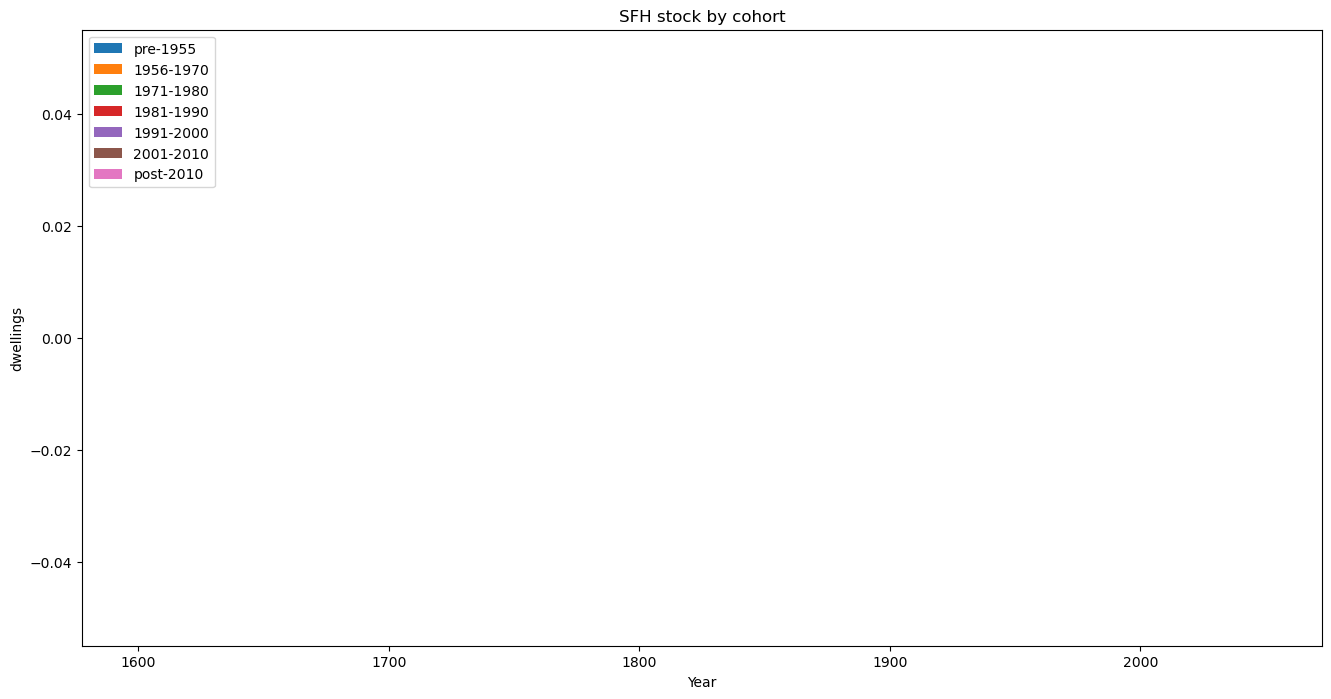

In [18]:
# Plot SFH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), SFH_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    SFH_stock_by_tabula_cohort.loc[:,'1956-1970'],
    SFH_stock_by_tabula_cohort.loc[:,'1971-1980'],
    SFH_stock_by_tabula_cohort.loc[:,'1981-1990'],
    SFH_stock_by_tabula_cohort.loc[:,'1991-2000'],
    SFH_stock_by_tabula_cohort.loc[:,'2001-2010'],
    SFH_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('SFH stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Make a stackplot of TH by tabula cohorts

Text(0, 0.5, 'dwellings')

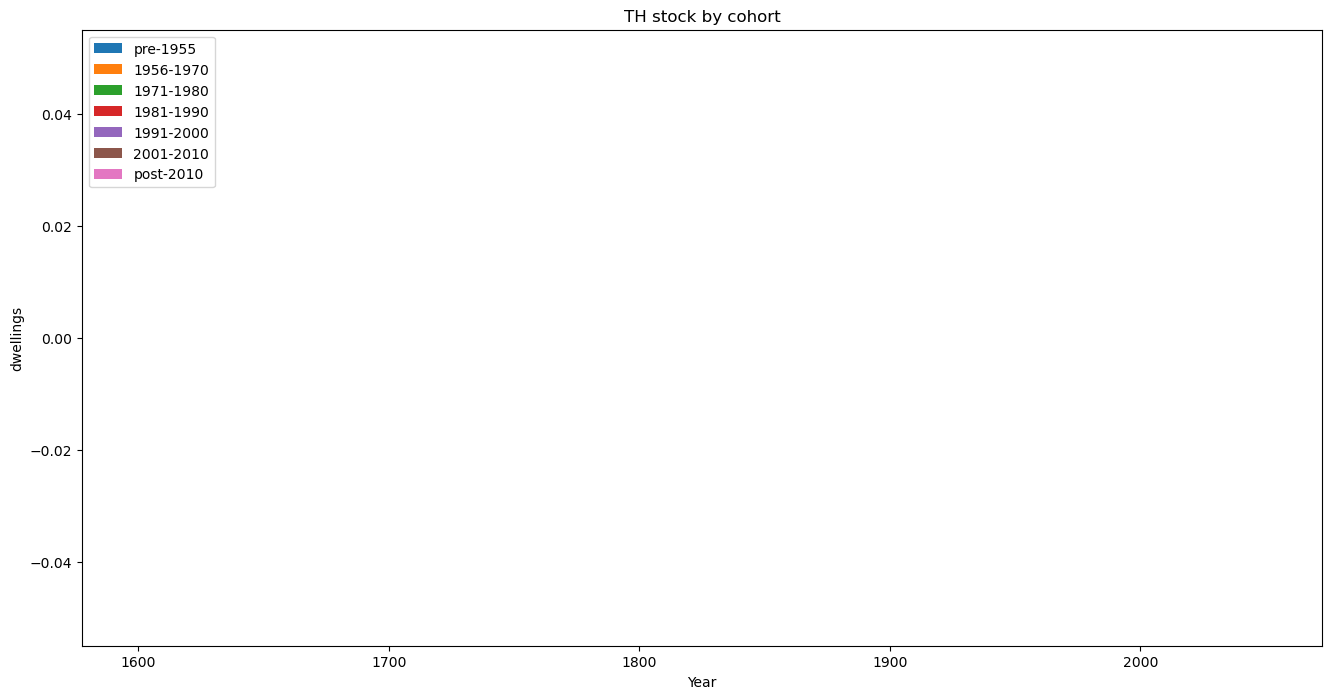

In [19]:
# Plot TH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), TH_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    TH_stock_by_tabula_cohort.loc[:,'1956-1970'],
    TH_stock_by_tabula_cohort.loc[:,'1971-1980'],
    TH_stock_by_tabula_cohort.loc[:,'1981-1990'],
    TH_stock_by_tabula_cohort.loc[:,'1991-2000'],
    TH_stock_by_tabula_cohort.loc[:,'2001-2010'],
    TH_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('TH stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Make a stackplot of AB by tabula cohorts

Text(0, 0.5, 'dwellings')

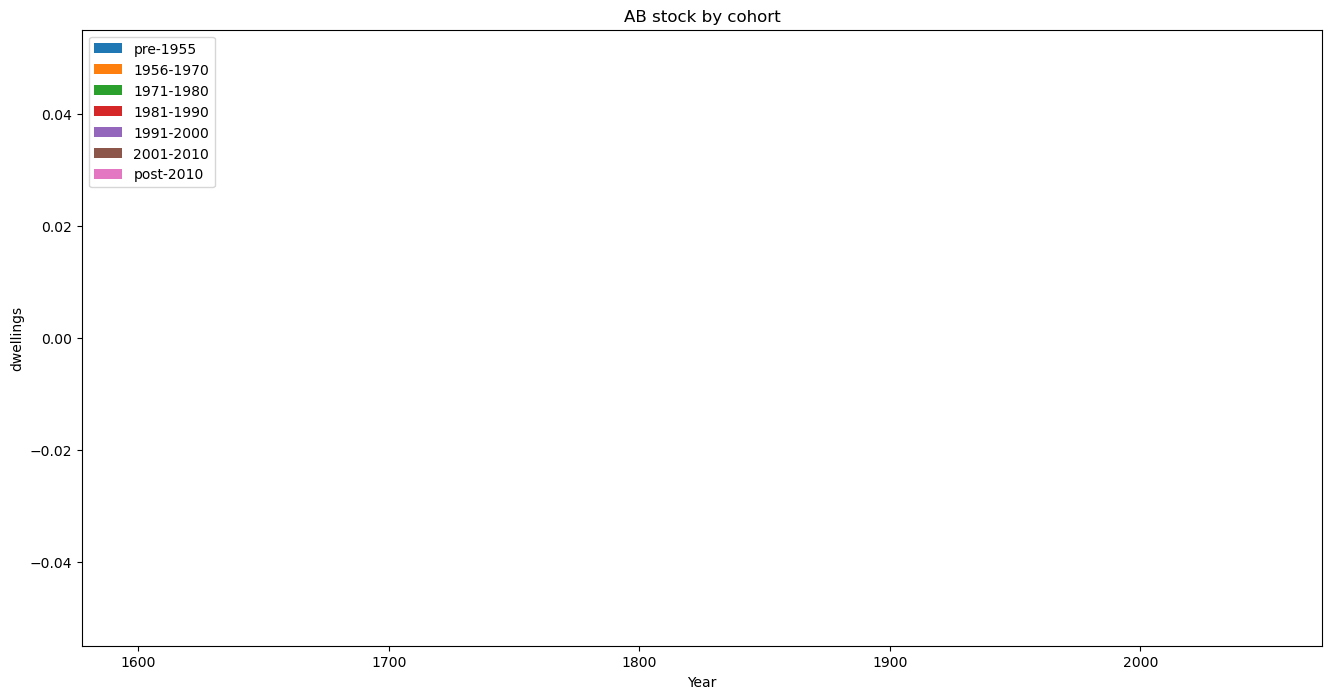

In [20]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), AB_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    AB_stock_by_tabula_cohort.loc[:,'1956-1970'],
    AB_stock_by_tabula_cohort.loc[:,'1971-1980'],
    AB_stock_by_tabula_cohort.loc[:,'1981-1990'],
    AB_stock_by_tabula_cohort.loc[:,'1991-2000'],
    AB_stock_by_tabula_cohort.loc[:,'2001-2010'],
    AB_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('AB stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Calculate total stock (s_total), total stock by cohort (s_c_total)

Calculate stock_changes by inflow - outflow for each type and aggregated

Calculate total inflows and outflows



In [21]:
s_total = s_SFH + s_TH + s_AB

total_stock_by_tabula_cohort = SFH_stock_by_tabula_cohort + TH_stock_by_tabula_cohort + AB_stock_by_tabula_cohort

stock_change_SFH = i_SFH - o_SFH
stock_change_TH = i_TH - o_TH
stock_change_AB = i_AB - o_AB

stock_change_total = stock_change_SFH + stock_change_TH + stock_change_AB

i_total = i_SFH + i_TH + i_AB

o_total = o_SFH + o_TH + o_AB

Plot total stock change

Text(0, 0.5, 'dwellings')

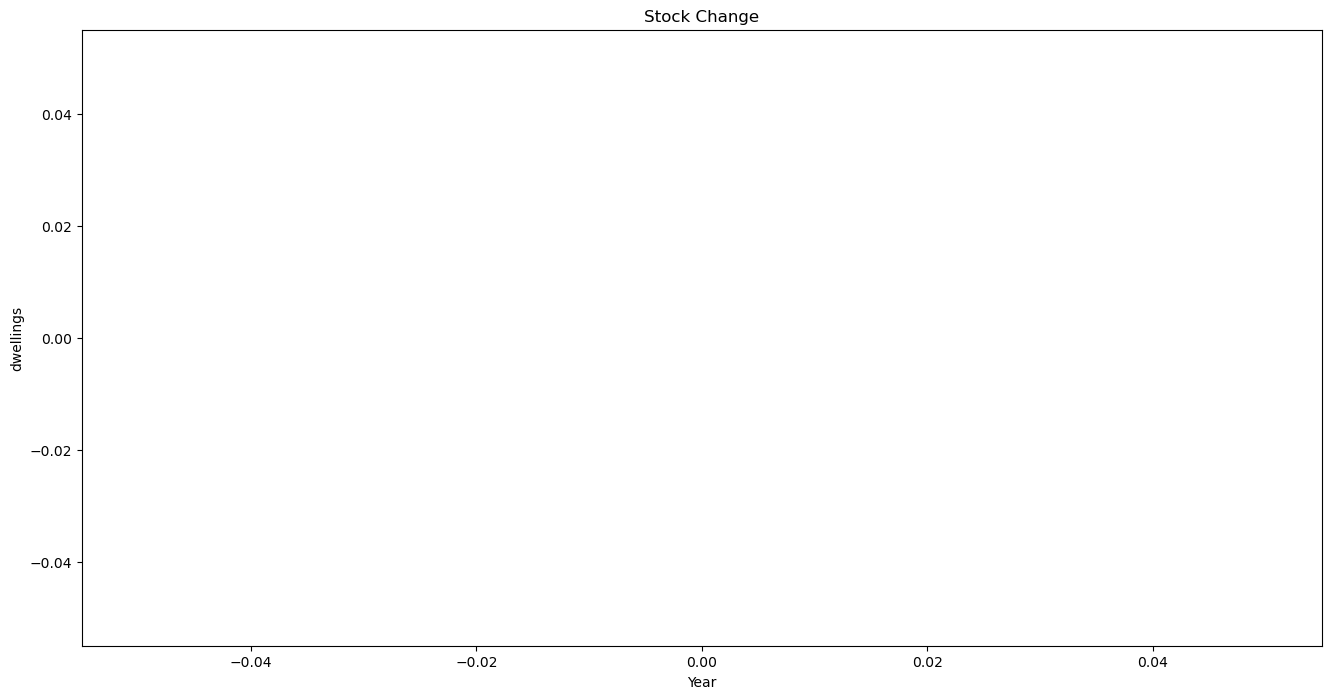

In [22]:
# Plot total stock change
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), stock_change_total.sum(axis=1))
plt.title('Stock Change')
plt.xlabel('Year')
plt.ylabel('dwellings')

Plot total stock by type

Text(0, 0.5, 'dwellings')

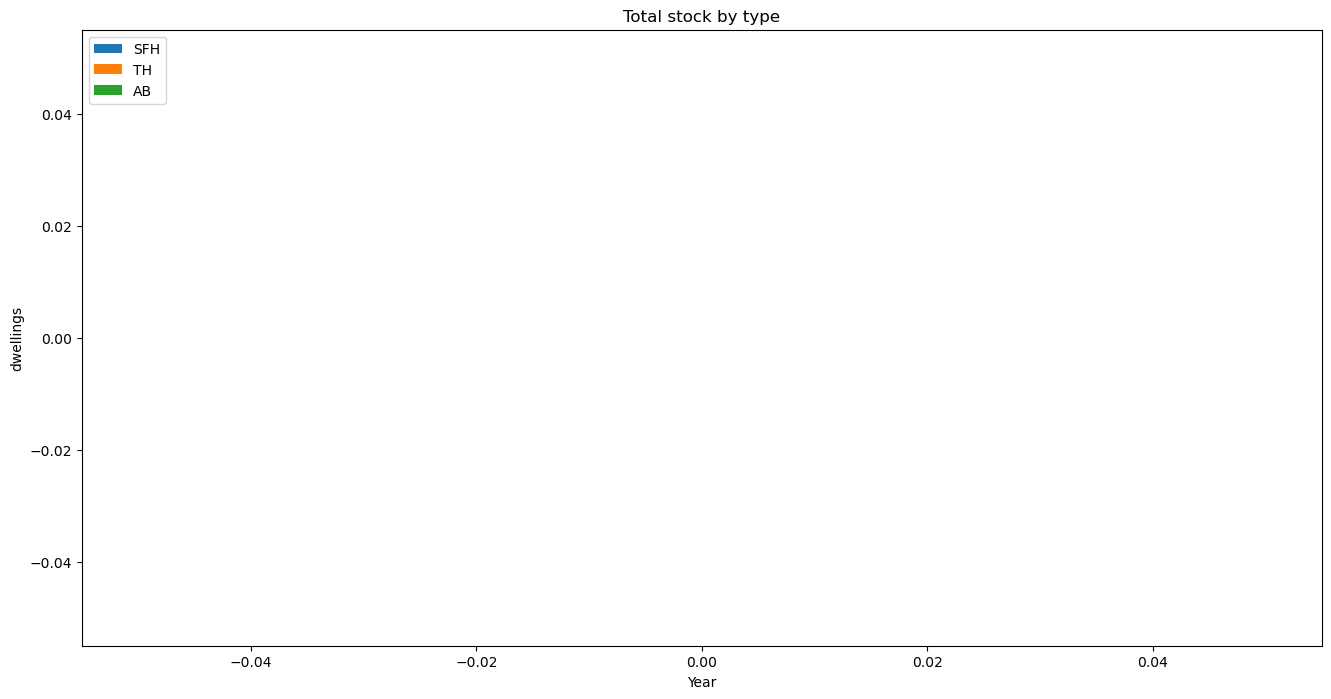

In [23]:
# Plot TH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), 
    s_SFH, s_TH, s_AB,
    labels=['SFH', 'TH', 'AB']
    )

plt.title('Total stock by type')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Plot total stock by cohort

Text(0, 0.5, 'dwellings')

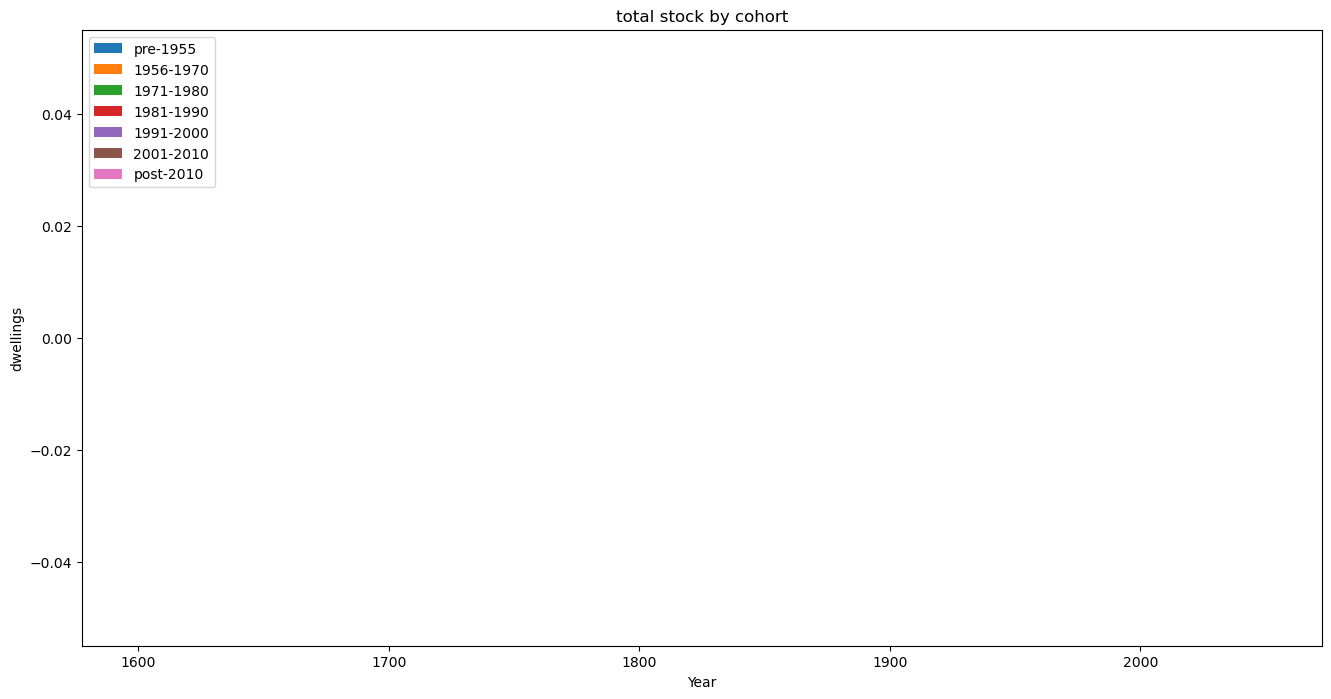

In [24]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), total_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    total_stock_by_tabula_cohort.loc[:,'1956-1970'],
    total_stock_by_tabula_cohort.loc[:,'1971-1980'],
    total_stock_by_tabula_cohort.loc[:,'1981-1990'],
    total_stock_by_tabula_cohort.loc[:,'1991-2000'],
    total_stock_by_tabula_cohort.loc[:,'2001-2010'],
    total_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('total stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Plot total inflow by type

Text(0, 0.5, 'dwellings')

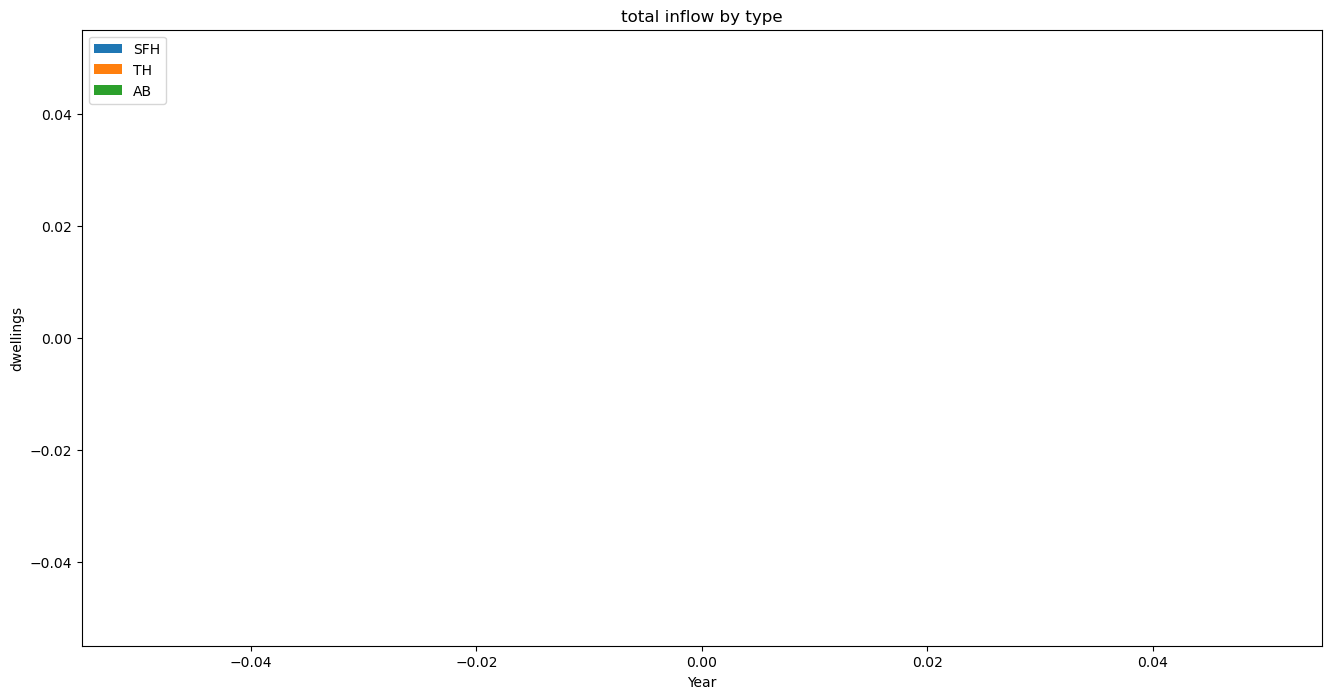

In [25]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), i_SFH, 
    i_TH,
    i_AB,
    labels=[
        'SFH', 'TH', 'AB']
    )

plt.title('total inflow by type')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Plot total outflow

Text(0, 0.5, 'dwellings')

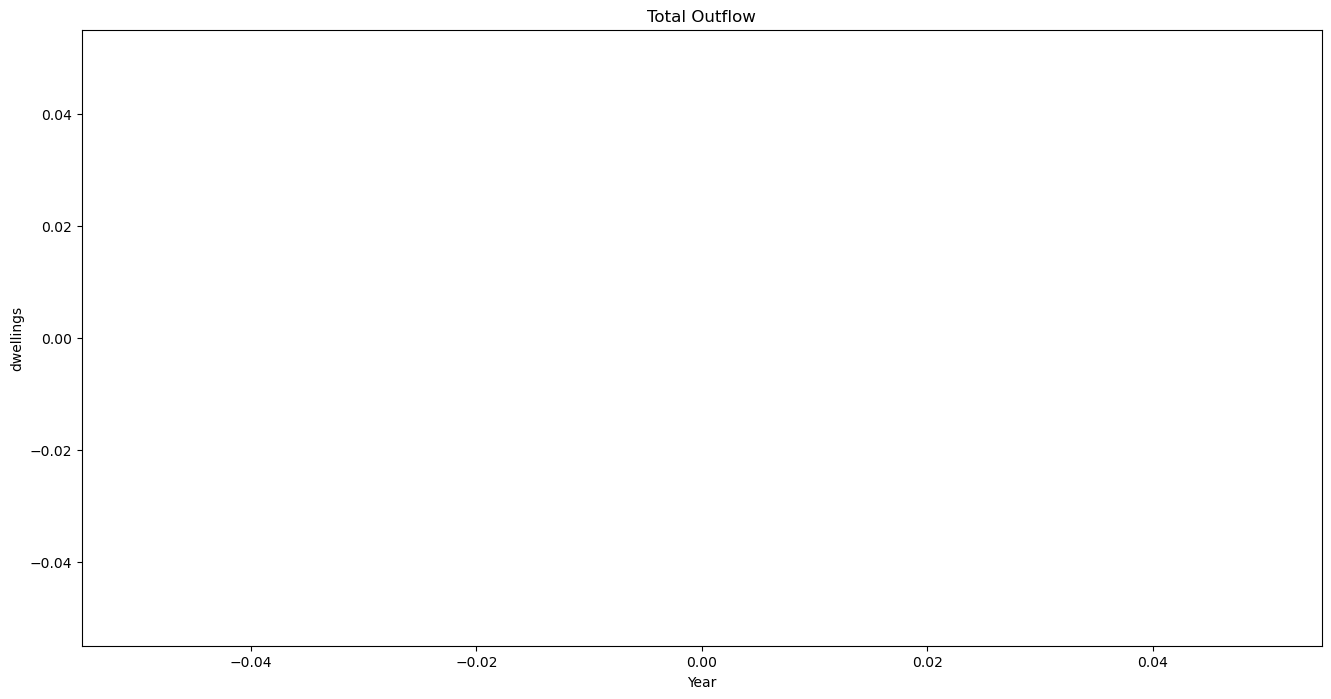

In [26]:
# Plot total outlfow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), o_total.sum(axis=1))
plt.title('Total Outflow')
plt.xlabel('Year')
plt.ylabel('dwellings')

Plot total inflow

Text(0, 0.5, 'dwellings')

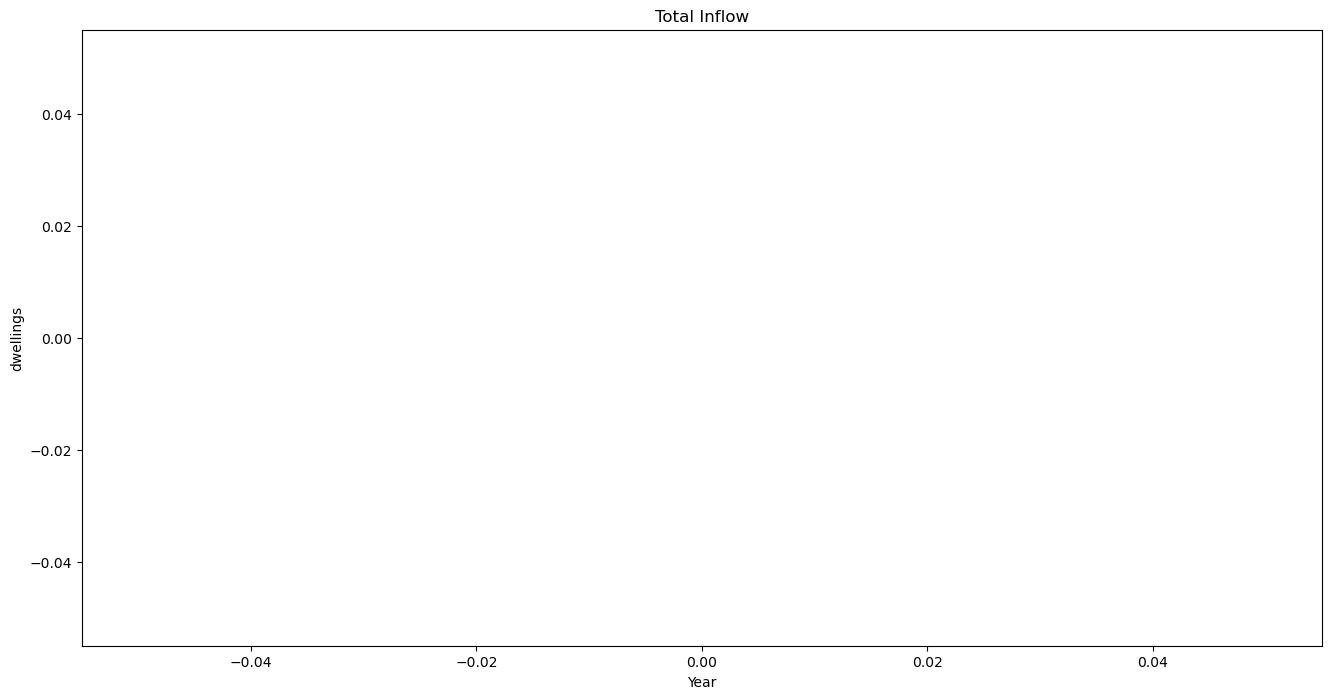

In [27]:
# Plot total inflow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), i_total)
plt.title('Total Inflow')
plt.xlabel('Year')
plt.ylabel('dwellings')

Convert number of dwellings into floor area by DSM cohort

In [28]:
s_UFA_c_SFH = s_c_SFH_df @ np.diag(UFApD['UFApD SFH'])
s_UFA_c_SFH = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH.columns = np.arange(1600, 2051)

s_UFA_c_TH = s_c_TH_df @ np.diag(UFApD['UFApD TH'])
s_UFA_c_TH = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH.columns = np.arange(1600, 2051)

s_UFA_c_AB = s_c_AB_df @ np.diag(UFApD['UFApD AB'])
s_UFA_c_AB = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB.columns = np.arange(1600, 2051)

i_SFH_UFA = i_SFH_df.mul(UFApD['UFApD SFH'].values, axis=0)
i_SFH_UFA = pd.DataFrame(i_SFH_UFA)


o_SFH_UFA = o_SFH_df @ np.diag(UFApD['UFApD SFH'])
o_SFH_UFA = pd.DataFrame(o_SFH_UFA)
o_SFH_UFA.columns = np.arange(1600, 2051)

i_TH_UFA = i_TH_df.mul(UFApD['UFApD TH'].values, axis=0)
i_TH_UFA = pd.DataFrame(i_TH_UFA)


o_TH_UFA = o_TH_df @ np.diag(UFApD['UFApD TH'])
o_TH_UFA = pd.DataFrame(o_TH_UFA)
o_TH_UFA.columns = np.arange(1600, 2051)

i_AB_UFA = i_AB_df.mul(UFApD['UFApD AB'].values, axis=0)
i_AB_UFA = pd.DataFrame(i_AB_UFA)

o_AB_UFA = o_AB_df @ np.diag(UFApD['UFApD AB'])
o_AB_UFA = pd.DataFrame(o_AB_UFA)
o_AB_UFA.columns = np.arange(1600, 2051)



# PLOT STOCK, INFLOW, OUTFLOW OF FLOOR AREA

total SFH stock (UFA)

Text(0, 0.5, 'UFA')

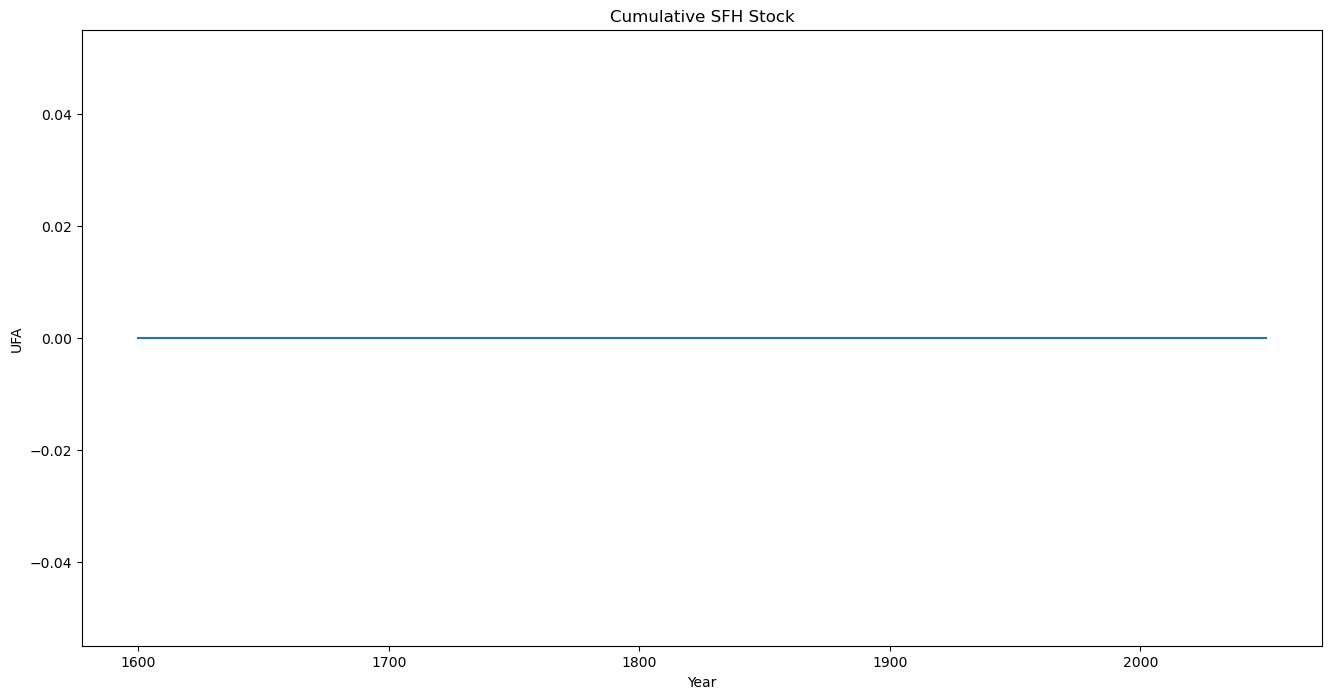

In [29]:
# Plot SFH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_UFA_c_SFH.sum(axis=1))
plt.title('Cumulative SFH Stock')
plt.xlabel('Year')
plt.ylabel('UFA')

total TH stock (UFA)

Text(0, 0.5, 'UFA')

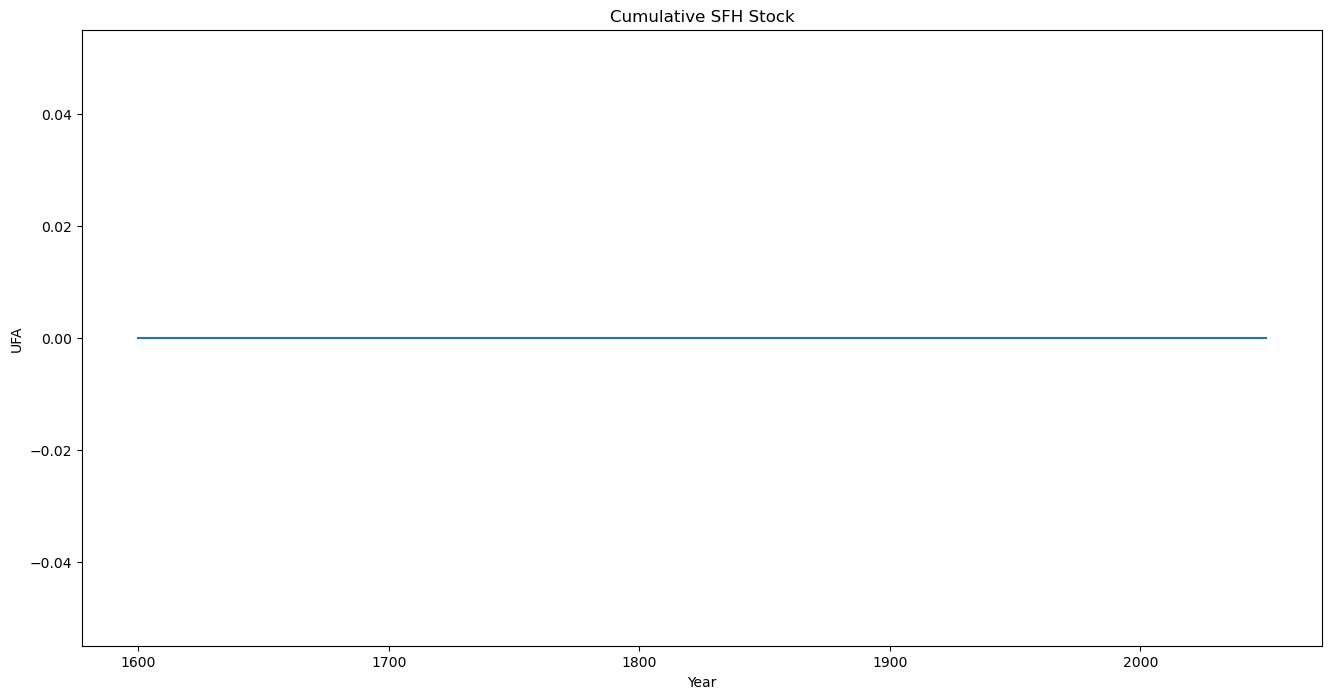

In [30]:
# Plot SFH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_UFA_c_TH.sum(axis=1))
plt.title('Cumulative SFH Stock')
plt.xlabel('Year')
plt.ylabel('UFA')

total AB stock (UFA)

Text(0, 0.5, 'UFA')

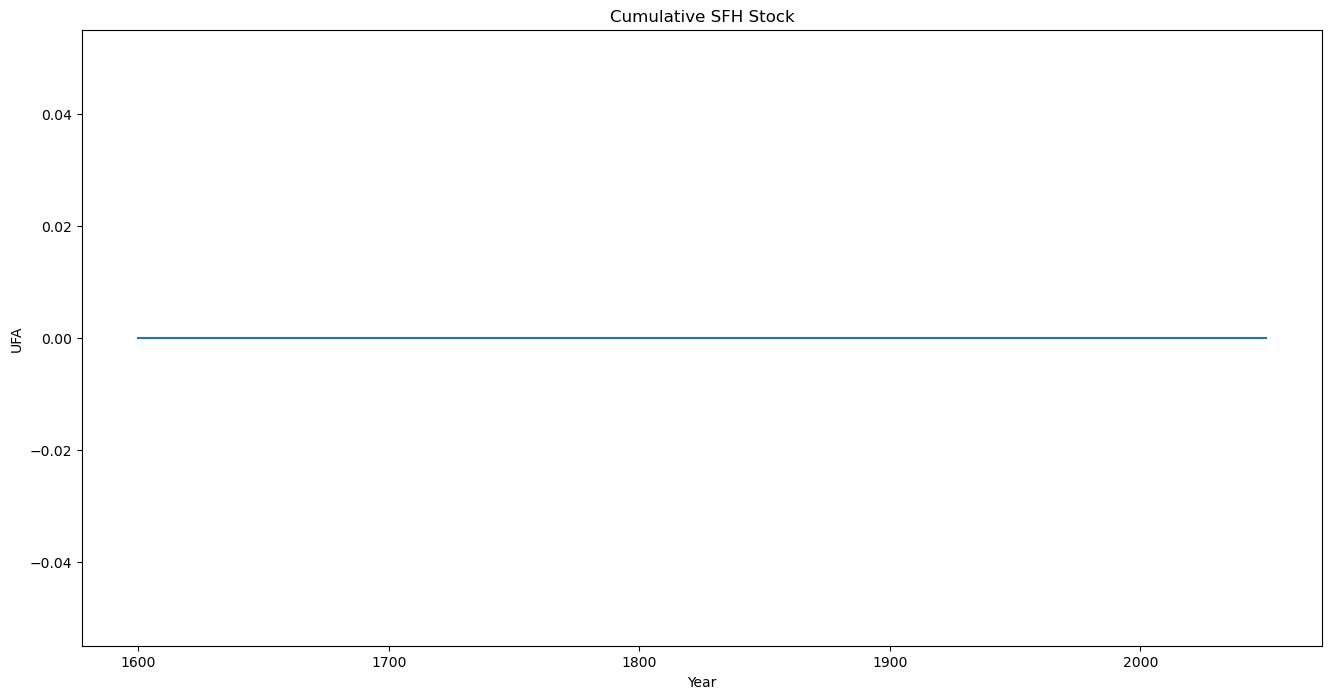

In [31]:
# Plot SFH total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), s_UFA_c_AB.sum(axis=1))
plt.title('Cumulative SFH Stock')
plt.xlabel('Year')
plt.ylabel('UFA')

Make s_c_UFA arrays into dataframes for easier use

In [32]:
UFApD.drop_duplicates(inplace=True)

s_UFA_c_SFH_df = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH_df = s_UFA_c_SFH_df.set_index(UFApD.index)
s_UFA_c_SFH_df.columns = np.arange(1600, 2051)
s_UFA_c_SFH_df

s_UFA_c_TH_df = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH_df = s_UFA_c_TH_df.set_index(UFApD.index)
s_UFA_c_TH_df.columns = np.arange(1600, 2051)
s_UFA_c_TH_df

s_UFA_c_AB_df = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB_df = s_UFA_c_AB_df.set_index(UFApD.index)
s_UFA_c_AB_df.columns = np.arange(1600, 2051)
s_UFA_c_AB_df

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [33]:
SFH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

TH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_TH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_TH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

AB_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_AB_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_AB_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

Make a stackplot of SFH UFA by tabula cohorts

Text(0, 0.5, 'UFA')

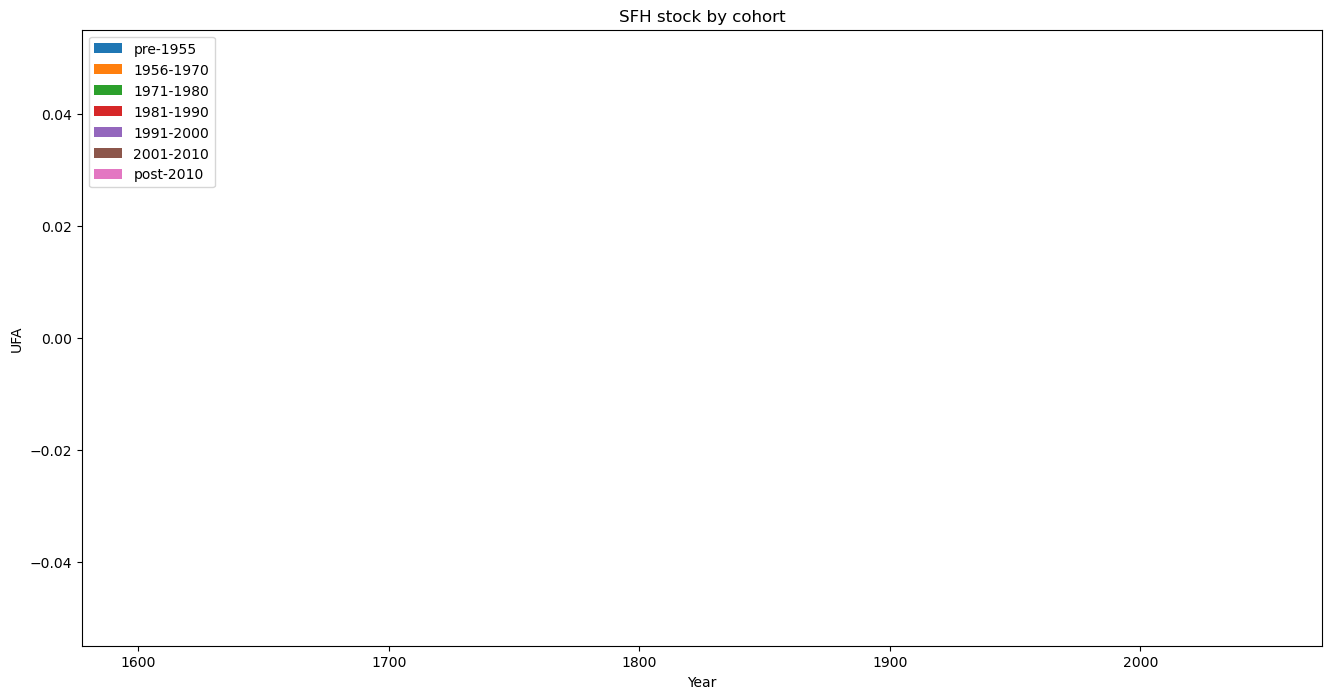

In [34]:
# Plot SFH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), SFH_UFA_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    SFH_UFA_stock_by_tabula_cohort.loc[:,'1956-1970'],
    SFH_UFA_stock_by_tabula_cohort.loc[:,'1971-1980'],
    SFH_UFA_stock_by_tabula_cohort.loc[:,'1981-1990'],
    SFH_UFA_stock_by_tabula_cohort.loc[:,'1991-2000'],
    SFH_UFA_stock_by_tabula_cohort.loc[:,'2001-2010'],
    SFH_UFA_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('SFH stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('UFA')

Make a stackplot of TH UFA by tabula cohorts

Text(0, 0.5, 'UFA')

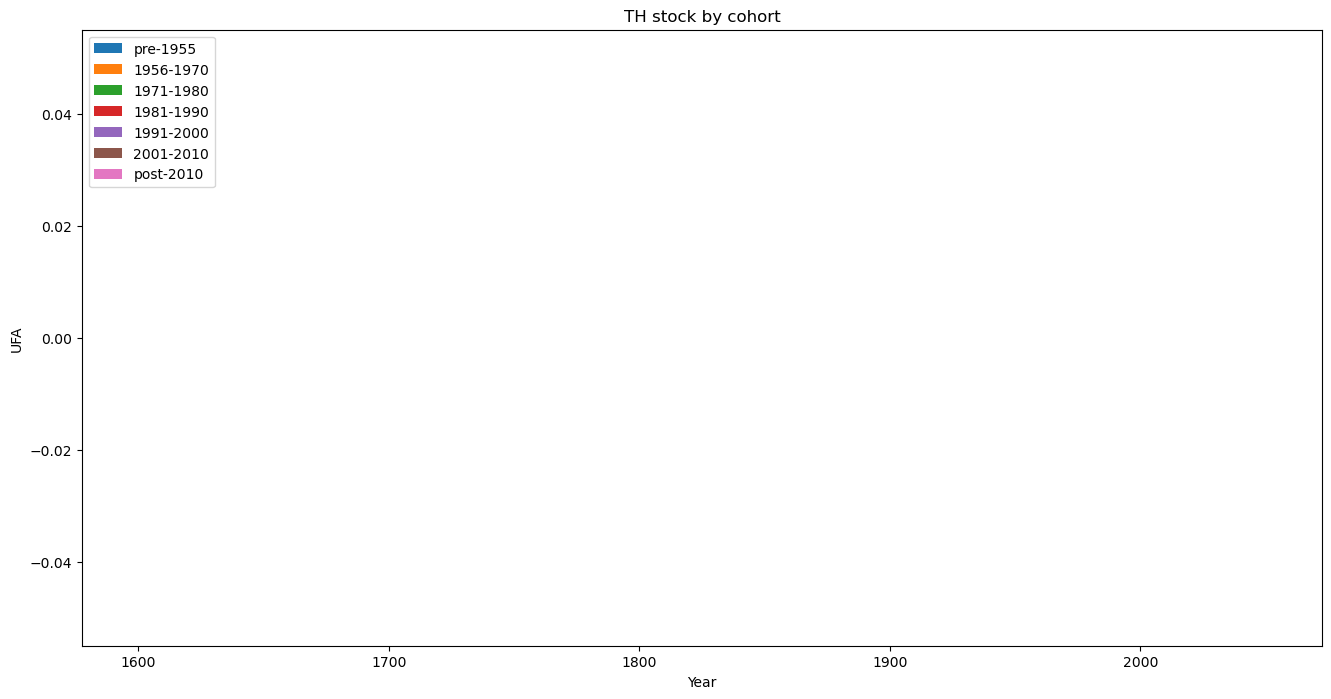

In [35]:
# Plot TH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), TH_UFA_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    TH_UFA_stock_by_tabula_cohort.loc[:,'1956-1970'],
    TH_UFA_stock_by_tabula_cohort.loc[:,'1971-1980'],
    TH_UFA_stock_by_tabula_cohort.loc[:,'1981-1990'],
    TH_UFA_stock_by_tabula_cohort.loc[:,'1991-2000'],
    TH_UFA_stock_by_tabula_cohort.loc[:,'2001-2010'],
    TH_UFA_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('TH stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('UFA')

Make a stackplot of AB UFA by tabula cohorts

Text(0, 0.5, 'dwellings')

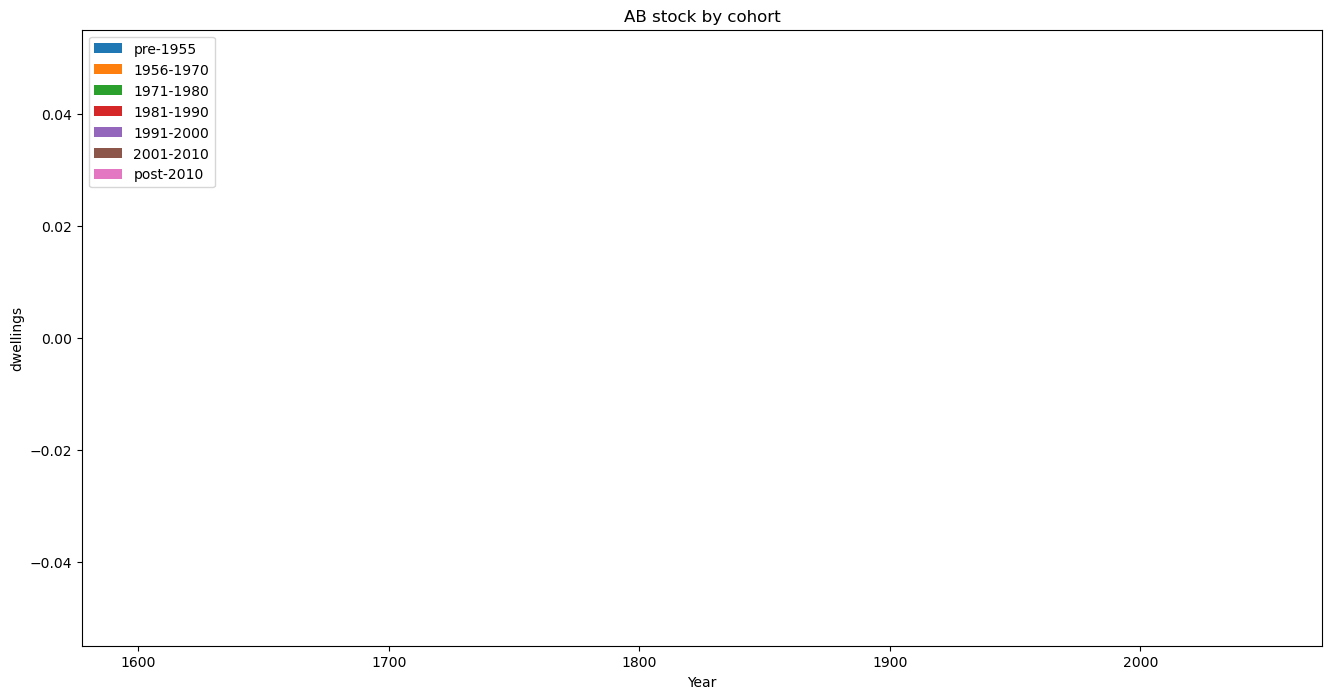

In [36]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), AB_UFA_stock_by_tabula_cohort.loc[:,'pre-1955'], 
    AB_UFA_stock_by_tabula_cohort.loc[:,'1956-1970'],
    AB_UFA_stock_by_tabula_cohort.loc[:,'1971-1980'],
    AB_UFA_stock_by_tabula_cohort.loc[:,'1981-1990'],
    AB_UFA_stock_by_tabula_cohort.loc[:,'1991-2000'],
    AB_UFA_stock_by_tabula_cohort.loc[:,'2001-2010'],
    AB_UFA_stock_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('AB stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Calculate total stock (s_total), total stock by cohort (s_c_total)

Calculate stock_changes by inflow - outflow for each type and aggregated

Calculate total inflows and outflows

In [37]:
s_UFA_total = s_UFA_c_SFH.sum(axis=1) + s_UFA_c_TH.sum(axis=1) + s_UFA_c_AB.sum(axis=1)

total_stock_UFA_by_tabula_cohort = SFH_UFA_stock_by_tabula_cohort + TH_UFA_stock_by_tabula_cohort + AB_UFA_stock_by_tabula_cohort

stock_change_SFH_UFA = i_SFH_UFA - pd.DataFrame(o_SFH_UFA.sum(axis=1))
stock_change_TH_UFA = i_TH_UFA - pd.DataFrame(o_TH_UFA.sum(axis=1))
stock_change_AB_UFA = i_AB_UFA - pd.DataFrame(o_AB_UFA.sum(axis=1))

stock_change_total_UFA = stock_change_SFH_UFA + stock_change_TH_UFA + stock_change_AB_UFA

i_total_UFA = i_SFH_UFA + i_TH_UFA + i_AB_UFA

o_total_UFA = o_SFH_UFA + o_TH_UFA + o_AB_UFA

Plot stock change UFA

Text(0, 0.5, 'dwellings')

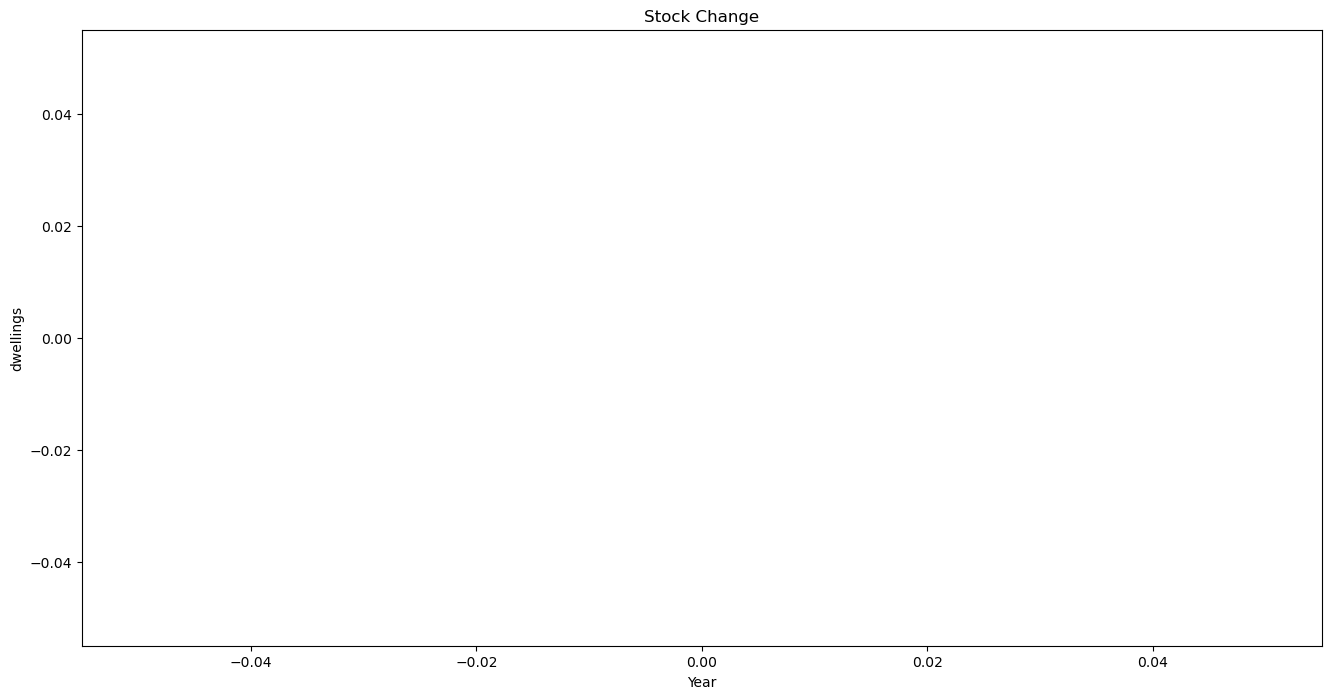

In [38]:
# Plot total stock change
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), stock_change_total_UFA)
plt.title('Stock Change')
plt.xlabel('Year')
plt.ylabel('dwellings')

Plot tota stock UFA by type

Text(0, 0.5, 'dwellings')

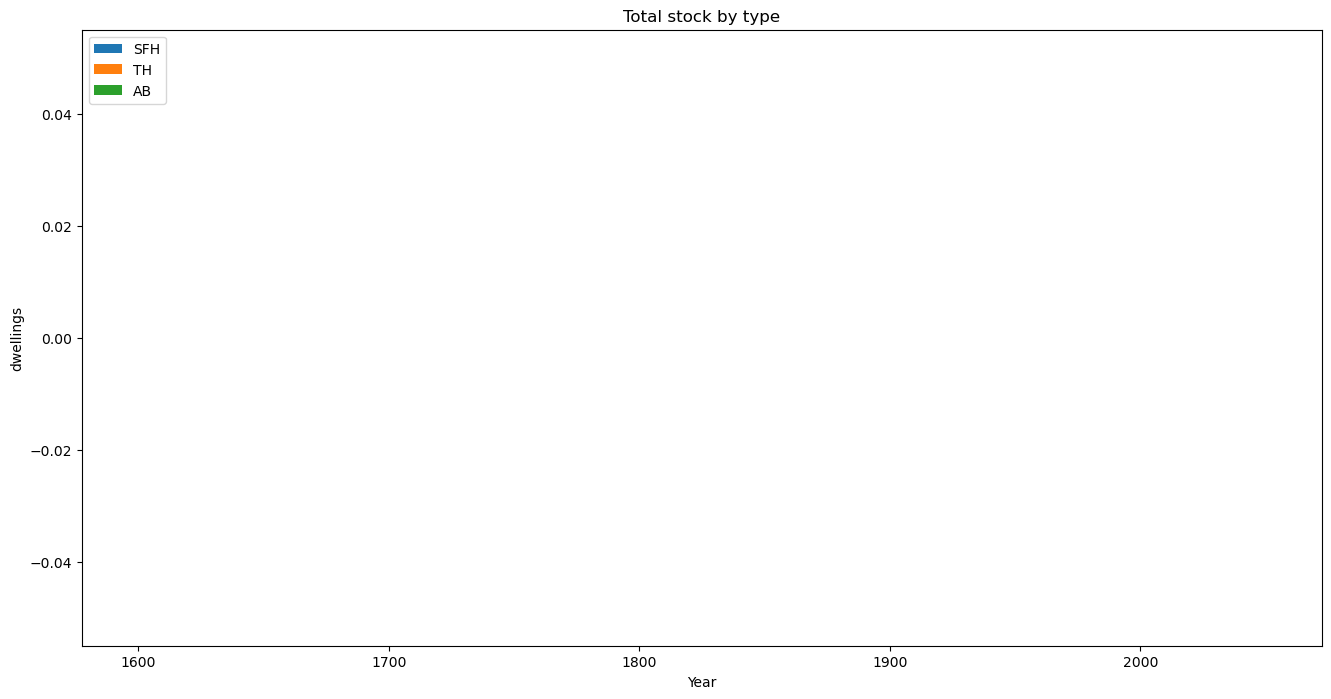

In [39]:
# Plot TH stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), 
    s_UFA_c_SFH.sum(axis=1), s_UFA_c_TH.sum(axis=1), s_UFA_c_AB.sum(axis=1),
    labels=['SFH', 'TH', 'AB']
    )

plt.title('Total stock by type')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Plot total stock UFA by cohort

Text(0, 0.5, 'dwellings')

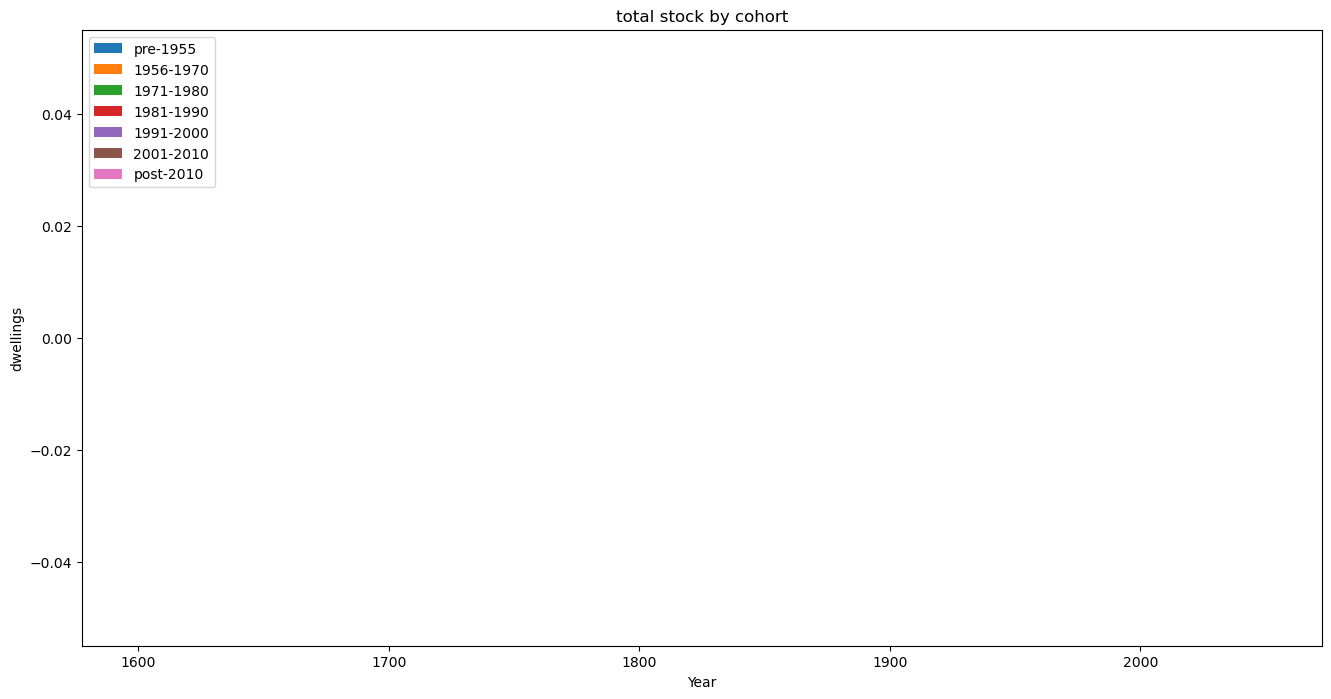

In [40]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), total_stock_UFA_by_tabula_cohort.loc[:,'pre-1955'], 
    total_stock_UFA_by_tabula_cohort.loc[:,'1956-1970'],
    total_stock_UFA_by_tabula_cohort.loc[:,'1971-1980'],
    total_stock_UFA_by_tabula_cohort.loc[:,'1981-1990'],
    total_stock_UFA_by_tabula_cohort.loc[:,'1991-2000'],
    total_stock_UFA_by_tabula_cohort.loc[:,'2001-2010'],
    total_stock_UFA_by_tabula_cohort.loc[:,'post-2010'],
    labels=[
        'pre-1955', '1956-1970', '1971-1980', '1981-1990', '1991-2000', 
        '2001-2010', 'post-2010']
    )

plt.title('total stock by cohort')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('dwellings')

Plot total inflow UFA by type

Text(0, 0.5, 'UFA')

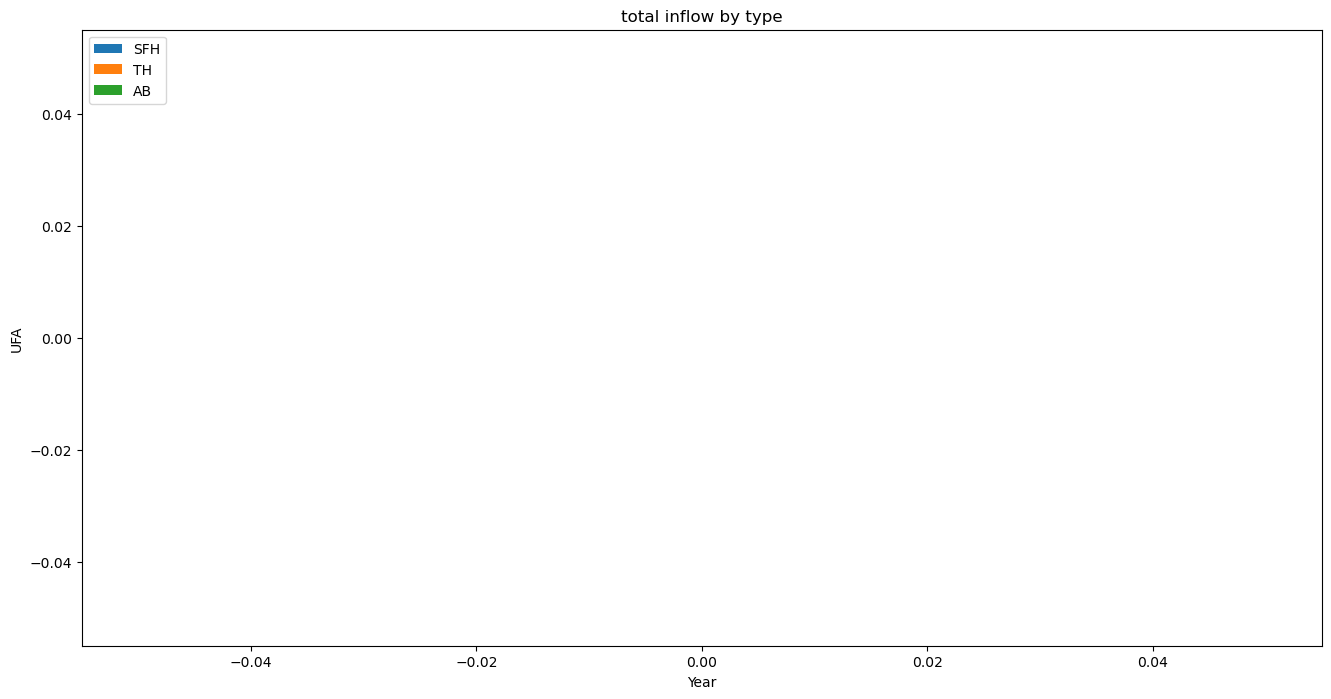

In [41]:
# Plot AB stock by tabula cohort
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), i_SFH_UFA.T, 
    i_TH_UFA.T,
    i_AB_UFA.T,
    labels=[
        'SFH', 'TH', 'AB']
    )

plt.title('total inflow by type')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('UFA')

Plot total outflow UFA

Text(0, 0.5, 'dwellings')

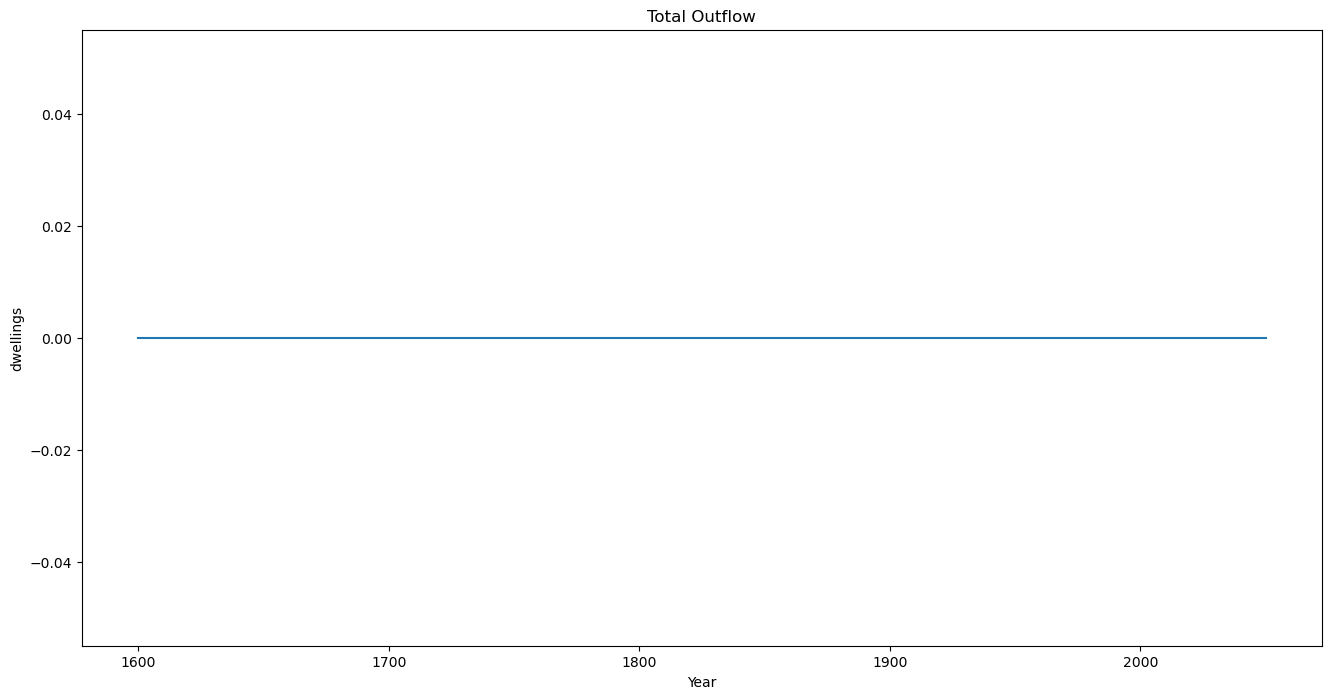

In [42]:
# Plot total outlfow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), o_total_UFA.sum(axis=1))
plt.title('Total Outflow')
plt.xlabel('Year')
plt.ylabel('dwellings')

plot total inflow UFA

Text(0, 0.5, 'dwellings')

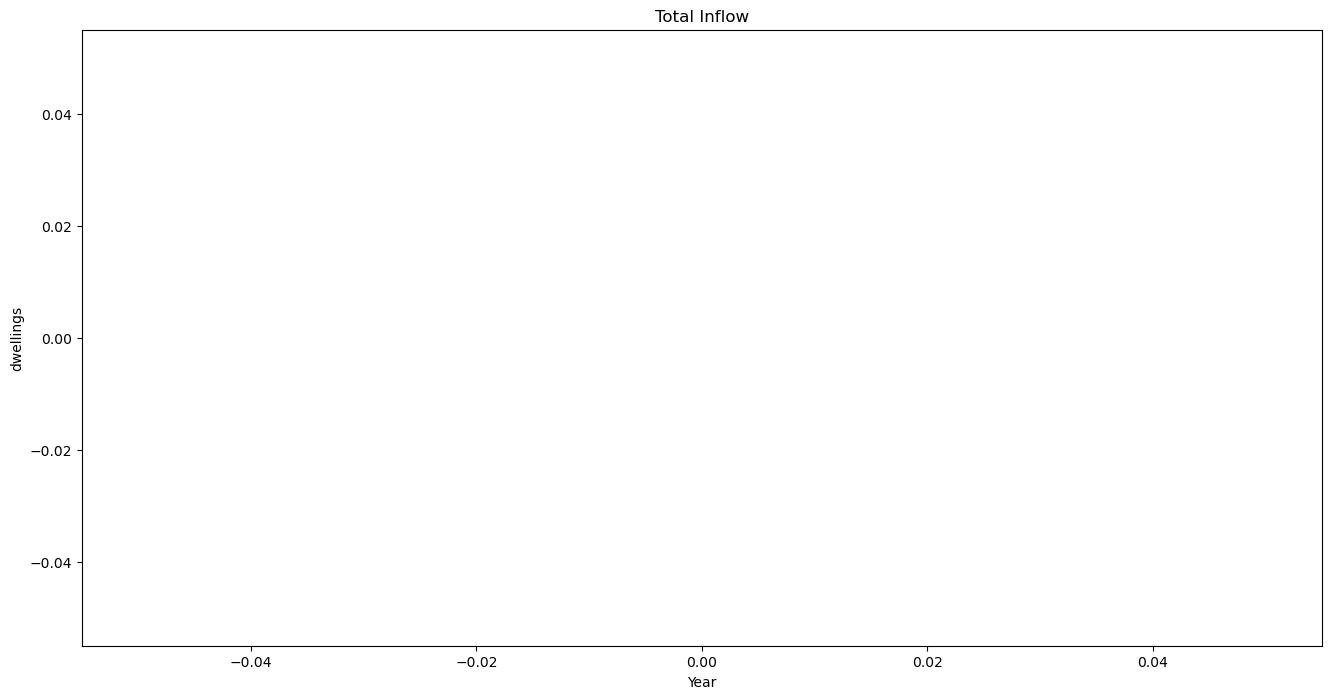

In [43]:
# Plot total inflow
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), i_total_UFA)
plt.title('Total Inflow')
plt.xlabel('Year')
plt.ylabel('dwellings')

Define a function that calculates energy use for SFH, original renovation level

In [44]:
def energy_use_calculation_SFH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('pre 1955' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1956-70' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1971-80' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1981-90' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1991-2000' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2001-2010' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2011-' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of SFH by DSM cohort

In [45]:
energy_use_matrix_SFH = energy_use_calculation_SFH(s_UFA_c_SFH)
energy_use_matrix_SFH

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


calculate vector of energy use for SFH (not by cohort)

In [46]:
energy_use_vector_SFH = energy_use_matrix_SFH.sum(axis=1)
energy_use_vector_SFH

Year
1600    0.0
1601    0.0
1602    0.0
1603    0.0
1604    0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Length: 451, dtype: float64

Define a function that calculates energy use for TH, original renovation level

In [47]:
def energy_use_calculation_TH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('pre 1955' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1956-70' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1971-80' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1981-90' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1991-2000' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2001-2010' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2011-' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of TH by DSM cohort

In [48]:
energy_use_matrix_TH = energy_use_calculation_TH(s_UFA_c_TH)
energy_use_matrix_TH

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


calculate vector of energy use for TH (not by cohort)

In [49]:
energy_use_vector_TH = energy_use_matrix_TH.sum(axis=1)
energy_use_vector_TH

Year
1600    0.0
1601    0.0
1602    0.0
1603    0.0
1604    0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Length: 451, dtype: float64

Define a function that calculates energy use for AB, original renovation level

In [50]:
def energy_use_calculation_AB(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('pre 1955' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1956-70' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1971-80' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1981-90' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1991-2000' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2001-2010' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2011-' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of AB by DSM cohort

In [51]:
energy_use_matrix_AB = energy_use_calculation_AB(s_UFA_c_AB)
energy_use_matrix_AB

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


calculate vector of energy use for AB (not by cohort)

In [52]:
energy_use_vector_AB = energy_use_matrix_AB.sum(axis=1)
energy_use_vector_AB

Year
1600    0.0
1601    0.0
1602    0.0
1603    0.0
1604    0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Length: 451, dtype: float64

In [53]:
energy_use_matrix_total = energy_use_matrix_SFH + energy_use_matrix_TH + energy_use_matrix_AB

In [54]:
energy_use_vectors_concatenated = pd.concat([energy_use_vector_SFH, energy_use_vector_TH, energy_use_vector_AB], axis=1)
energy_use_vectors_concatenated = energy_use_vectors_concatenated.rename(columns={0: 'SFH', 1: 'TH', 2: 'AB'})

#energy_use_vectors_concatenated = pd.concat([energy_use_vectors_concatenat1, energy_use_vector_AB], axis=1)

energy_use_vectors_concatenated 

,SFH,TH,AB
Year,,,
1600,0.0,0.0,0.0
1601,0.0,0.0,0.0
1602,0.0,0.0,0.0
1603,0.0,0.0,0.0
1604,0.0,0.0,0.0
...,...,...,...
2046,0.0,0.0,0.0
2047,0.0,0.0,0.0
2048,0.0,0.0,0.0


Make two stack line charts for energy use by cohort and by type

Energy use by type

Text(0, 0.5, 'Energy Use')

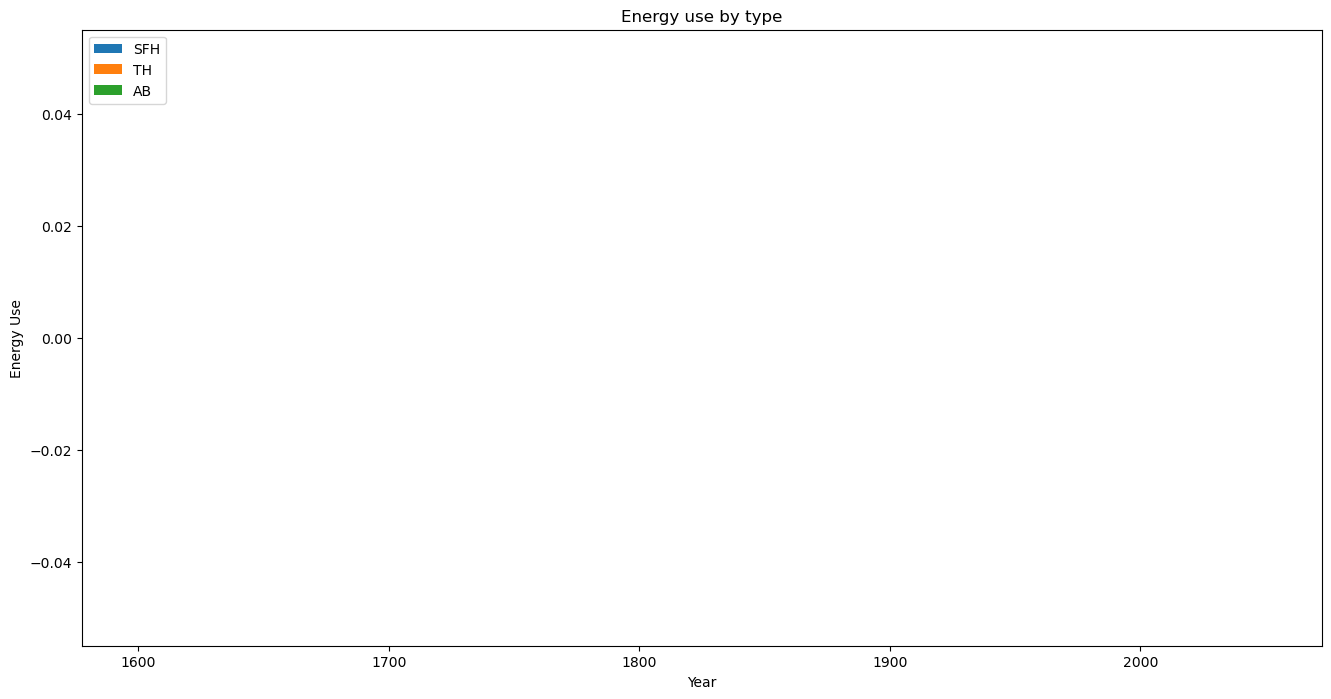

In [55]:
# 
plt.figure(figsize=(16, 8))

plt.stackplot(
    np.arange(1600, 2051), 
    energy_use_vector_SFH, energy_use_vector_TH, energy_use_vector_AB,
    labels=['SFH', 'TH', 'AB']
    )

plt.title('Energy use by type')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.ylabel('Energy Use')

In [56]:
s_UFA_c_total = s_UFA_c_SFH + s_UFA_c_TH + s_UFA_c_AB

s_UFA_c_total


,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
UFA_total = s_UFA_c_total.sum(axis=1)
UFA_total

Year
1600    0.0
1601    0.0
1602    0.0
1603    0.0
1604    0.0
       ... 
2046    0.0
2047    0.0
2048    0.0
2049    0.0
2050    0.0
Length: 451, dtype: float64

Text(0, 0.5, 'dwellings')

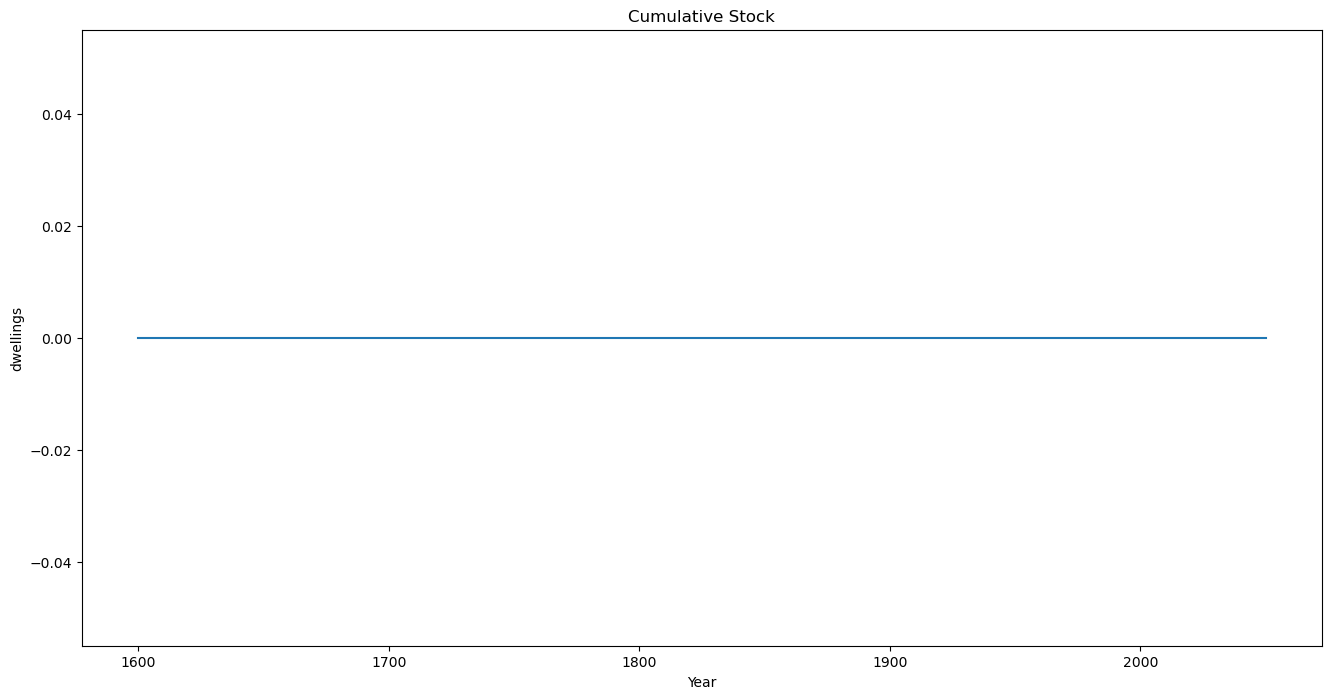

In [58]:
# Plot total stock
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1600, 2051), UFA_total)
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('dwellings')